In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize

In [71]:
global T4_Arclight, T4_Gcamp

In [64]:
temp = np.genfromtxt('data/Edge/Bulle/ArcLight_Edge_TimeSeries.txt', delimiter='\t')

In [65]:
T4_Arclight = temp[:,np.arange(1, temp.shape[1], 2)]

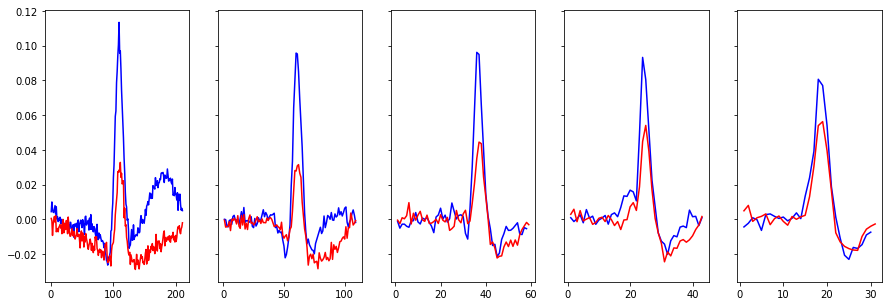

In [66]:
f, ax = plt.subplots(1,5, sharey=True, figsize=(15,5))
[ax[i].plot(T4_Arclight[:,2*i],'b') for i in range(5)];
[ax[i].plot(T4_Arclight[:,2*i+1], 'r') for i in range(5)];

In [72]:
DATAPATH = os.path.join(os.getcwd(),'data/Edge/Abhishek/SPARC/ONEdge/')
df_list = os.listdir(DATAPATH)
#df_list
df_SPARC_Abhi_ONEdge = pd.read_pickle(DATAPATH + df_list[0])
for i in range(1, len(df_list)):
    df_SPARC_Abhi_ONEdge = df_SPARC_Abhi_ONEdge.join(pd.read_pickle(DATAPATH+df_list[i]))
df_SPARC_Abhi_ONEdge.index.name = 'time'
df_SPARC_Abhi_ONEdge = df_SPARC_Abhi_ONEdge.reset_index()

In [73]:
T4_Gcamp = df_SPARC_Abhi_ONEdge.values[:,np.arange(1, temp.shape[1], 2)]

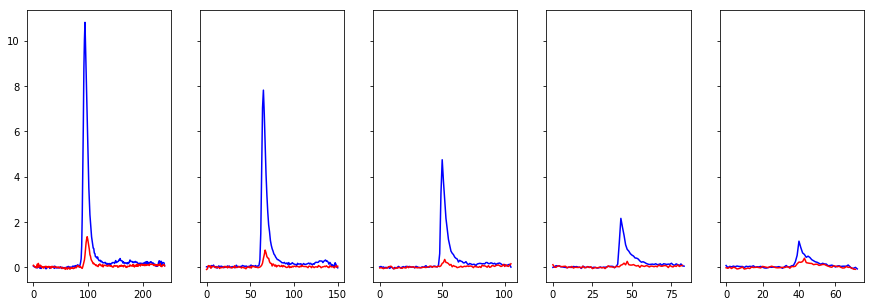

In [74]:
f, ax = plt.subplots(1,5, sharey=True, figsize=(15,5))
[ax[i].plot(T4_Gcamp[:,2*i],'b') for i in range(5)];
[ax[i].plot(T4_Gcamp[:,2*i+1], 'r') for i in range(5)];

In [75]:
def load_data(filename):
    x = scipy.io.loadmat(filename)['PDmean']
    return x

def plot_data(x, title, savefig=False, dt=0.0769, color='k'):
    x_df = pd.DataFrame(x)  #Put data into Pandas dataframe
    x_df.index = x_df.index*dt  #convert index to time in seconds
    x_df.plot(subplots=True, layout=(12, 4), figsize=(20, 20), sharey=True, legend=False, color=color);
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres=0):
    x_copy = x.copy()
    x_copy[x_copy<thres] = 0
    return x_copy

# def Ca_model(x, p, dt=0.0769):
#     x_thres = threshold_cut(x, p['thres'])
#     x_thres_bp1 = bandpass(x_thres, p['tauhp'], p['taulp1'], dt)
#     x_1 = x_thres_bp1 * p['gain1']
#     x_thres_bp2 = bandpass(x_thres, p['tauhp'], p['taulp2'], dt)
#     x_2 = x_thres_bp2 * p['gain2']
#     y = x_1 + x_2
#     return y

def Ca_model(x, p, dt=0.0769):
    """ p is a tuple containing parameters in this order : thres, tauhp, taulp1, gain1, taulp2, gain2"""
    x_thres = threshold_cut(x, p[0])
    x_thres_bp1 = bandpass(x_thres, p[1], p[2], dt)
    x_1 = x_thres_bp1 * p[3]
    x_thres_bp2 = bandpass(x_thres, p[1], p[4], dt)
    x_2 = x_thres_bp2 * p[5]
    y = x_1 + x_2
    #y = np.roll(y, p[6], axis=0)
    return y
    

In [87]:
def calc_error(p):
    T4Ca_model = Ca_model(T4_Arclight, p)
    #T4Ca_model = np.roll(T4Ca_model, p[6], axis = 0)
    #error = np.sqrt(np.mean((T4_Gcamp-T4Ca_model)**2))
    error = np.sqrt(np.mean((np.nanmax(T4_Gcamp, axis=0)-np.nanmax(T4Ca_model, axis=0))**2))
    return error

In [88]:
res = minimize(calc_error, (0.0, 0.05, 3.0, 100.0, 3.0, 60.0))
res

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """


      fun: nan
 hess_inv: array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])
      jac: array([nan, nan, nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 8
      nit: 0
     njev: 1
   status: 2
  success: False
        x: array([0.e+00, 5.e-02, 3.e+00, 1.e+02, 3.e+00, 6.e+01])

In [89]:
model_p = res.x
model_p[0]

0.0

In [90]:
T4Ca_model = Ca_model(T4_Arclight, model_p)

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


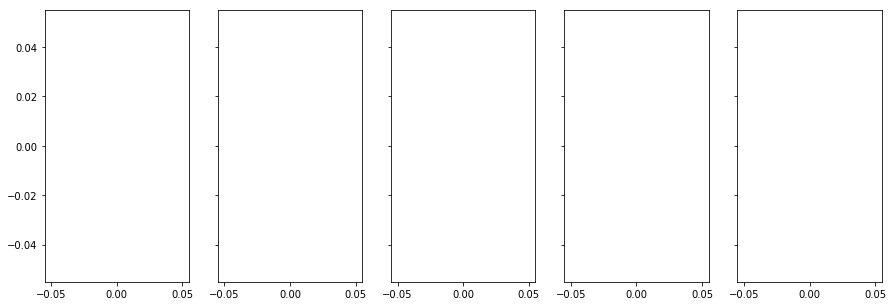

In [91]:
f, ax = plt.subplots(1,5, sharey=True, figsize=(15,5))
[ax[i].plot(T4Ca_model[:,2*i],'b') for i in range(5)];
[ax[i].plot(T4Ca_model[:,2*i+1], 'r') for i in range(5)];

In [92]:
T4Ca_model.shape

(219, 10)

In [93]:
T4Ca_model

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])